In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
from urllib.parse import unquote
from tqdm import tqdm 
import seaborn as sns
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
from matplotlib.colors import Normalize

dataFolder = '../Data/wikispeedia_paths-and-graph/'
articlesDf = pd.read_csv(dataFolder+ 'articles.tsv')
articlesDf = articlesDf.iloc[10:]
articlesSeries  = pd.Series(articlesDf.index.map(lambda x : x[0])).map(lambda y : unquote(y,'utf-8'))
#articlesSeries.head(10)

linksDf = pd.read_csv(dataFolder + 'links.tsv', header=11, sep = '\t')
linksDf.columns = ['Elements','links']
linksDf['Elements'] = linksDf['Elements'].map(lambda x : unquote(x, 'utf-8'))
linksDf['links'] = linksDf['links'].map(lambda x : unquote(x, 'utf-8'))
#linksDf.reset_index()

categoriesDf = pd.read_csv(dataFolder + 'categories.tsv', header=11, sep= '\t')
categoriesDf.index = categoriesDf.index.map(lambda x : unquote(x,'utf-8'))
categoriesDf.columns = ['categories']
#categoriesDf

paths_finishedDf= pd.read_csv(dataFolder + 'paths_finished.tsv', header=15, sep= '\t')
paths_finishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'rating']
#paths_finishedDf

paths_unfinishedDf= pd.read_csv(dataFolder + 'paths_unfinished.tsv', header=16, sep= '\t')
paths_unfinishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'target', 'type']
#paths_unfinishedDf

people_skin_color = pd.read_csv(dataFolder + 'ethnic_category.tsv', header=1, sep= '\t' )
people_skin_color.columns = ['Category', 'People', 'Skin Color']
people_skin_color['People'] = people_skin_color['People'].map(lambda x : unquote(x, 'utf-8'))
people_skin_color.reset_index()
people_skin_color

,Category,People,Skin Color
0,subject.People.Historical_figures,Óengus I of the Picts,White
1,subject.People.Historical_figures,Abbas I of Persia,Arab-Persian-Bizantin
2,subject.People.Historical_figures,Adam Smith,White
3,subject.People.Historical_figures,Adriaen van der Donck,White
4,subject.People.Historical_figures,Agamemnon,White
...,...,...,...
706,subject.People.Computing_People,Jimmy Wales,White
707,subject.People.Computing_People,Linus Torvalds,White
708,subject.People.Computing_People,Richard Stallman,White
709,subject.People.Computing_People,Tim Berners-Lee,White


In [13]:
people_color =  pd.concat([people_skin_color, people_skin_color['Category'].str.split(".", expand=True)], axis=1)
people_color = people_color.drop(columns = ['Category', 0, 1])
people_color = people_color.rename(columns = {1 : 'Categories'})

unique_color=people_color['Skin Color'].unique()
rename = {
    'Blanc' : 'White',
    'Peau plus foncée' : 'Black',
    'Peau brune' : 'Black',
    'Peau plus foncée (Aborigène australien)' : 'Black',
    'Peau plus foncée (Asiatique)' : 'East Asian', 
    'Peau plus foncée (Moyen-Orient)' : 'Arab',
    'Peau plus foncée (Polynésien)' : 'Polynesian',
    'Peau plus foncée (Sherpa/Népalais)' : 'South Asian', 
    'Peau plus foncée (Ascendance africaine partielle)' : 'Black', 
    'Peau plus foncée (Indien)' : 'South Asian',
    'Peau plus foncée (Berbère)' : 'Arab',
    'Peau plus foncée (Arabe)' : 'Arab',
    'Peau plus foncée (Tibétain)' : 'East Asian',
    'Peau plus foncée (Persan)' : 'Arab',
    'Peau plus foncée (Juif)' : 'Arab', 
    'Peau plus foncée (Somalienne)' : 'Black', 
    'Peau plus foncée (Mixte)' : 'Black',
    'Peau plus foncée (Hispanique)' : 'Hispanic', 
    'Peau plus foncée (Indonésien)' : 'East Asian', 
    'Peau plus foncée (Japonais)' : 'East Asian',
    'Peau plus foncée (Vietnamien)' : 'East Asian', 
    'Peau plus foncée (Indienne)' : 'South Asian', 
    'Peau brune (Indien)' : 'South Asian',
    'Peau plus foncée (Palestinien)' : 'Arab',
    'Peau brune (Pakistano-Indien)' : 'South Asian', 
    "Blanc (D'origine libanaise)": 'White', 
    'Peau plus foncée (Brésilien)' : 'Hispanic'
}
people_color['Skin Color'] = people_color['Skin Color'].replace(rename)
people_color_dist=people_color['Skin Color'].value_counts()


In [14]:
# Lets create a dataframe that we will manipulate step by step in order to keep only datas that we want: 
people_links= linksDf

# We remove all accents and spaces within the dataframes 'people_color' (conatining all the people and their ethnic group) 
# and 'people_links' (containing all the wikipedia pages and their links) so that we can compare them easily: 
people_color.People= people_color.People.str.replace(' ', '_')
people_color.People= people_color.People.apply(unidecode)
people_links.Elements= people_links.Elements.apply(unidecode)

# We can now drop all links that don't bring to a person ('links' column of the 'people_links' dataframe)
indices_to_delete=[]
for i in range (0,len(people_links)): 
    if people_links['links'][i] not in people_color.People.values: 
        indices_to_delete=indices_to_delete + [i]
people_links= people_links.drop(indices_to_delete)
people_links=people_links.reset_index(drop=True)


In [15]:
# We add the ethnic group of the person on the link in a new column 'l_ethnic': 
l_ethnicity=[]
for i in range (0, len(people_links)):     
    for j in range (0, len(people_color)):
        if people_links['links'][i]== people_color['People'][j]:
            l_ethnicity= l_ethnicity+ [people_color['Skin Color'][j]]
            break 
people_links['l_ethnicity']= l_ethnicity
people_links.head(20)

,Elements,links,l_ethnicity
0,Aedan_mac_Gabrain,Columba,White
1,Edouard_Manet,Claude_Monet,White
2,Edouard_Manet,Edgar_Allan_Poe,White
3,Edouard_Manet,Francisco_Goya,White
4,Edouard_Manet,Raphael,White
5,Eire,George_VI_of_the_United_Kingdom,White
6,EUR2_commemorative_coins,Christopher_Columbus,White
7,EUR2_commemorative_coins,Galileo_Galilei,White
8,EUR2_commemorative_coins,Harold_Macmillan,White
9,EUR2_commemorative_coins,Miguel_de_Cervantes,White


In [16]:
# We can then count the number of links that bring to a person of certain ethnic group: 
links_per_ethnic_groups = people_links.groupby(['l_ethnicity']).size().reset_index(name='nb_links')
links_per_ethnic_groups

,l_ethnicity,nb_links
0,American Indian,3
1,Arab-Persian-Bizantin,295
2,Asian,343
3,Australian Aboriginal,1
4,Black,201
5,Hispanic,43
6,White,8827


In [18]:
# Now we can drop all wikipedia pages that are not a person ('Elements' column of the 'people_links' dataframe)
indices_to_delete=[]
for i in range (0,len(people_links)): 
    if people_links['Elements'][i] not in people_color.People.values: 
        indices_to_delete=indices_to_delete + [i]
people_links= people_links.drop(indices_to_delete)
people_links=people_links.reset_index(drop=True)
people_links

,Elements,links,l_ethnicity
0,Edouard_Manet,Claude_Monet,White
1,Edouard_Manet,Edgar_Allan_Poe,White
2,Edouard_Manet,Francisco_Goya,White
3,Edouard_Manet,Raphael,White
4,Abel_Tasman,James_Cook,White
...,...,...,...
2998,Zoroaster,Friedrich_Nietzsche,White
2999,Zoroaster,Jesus,Arab-Persian-Bizantin
3000,Zoroaster,Muhammad,Arab-Persian-Bizantin
3001,Zoroaster,Plato,White


In [19]:
# We can thus determine the ethnic group of every person on the 'Elements' column and put it in a new column 'E_ethnic':
E_ethnicity = []
for i in range (0, len(people_links)):
    for j in range (0, len(people_color)):
        if people_links['Elements'][i]== people_color['People'][j]:
            E_ethnicity= E_ethnicity + [people_color['Skin Color'][j]]
            break

In [21]:
people_links['E_ethnicity']= E_ethnicity
print(len(people_links))
people_links.head(20)


3003


,Elements,links,l_ethnicity,E_ethnicity
0,Edouard_Manet,Claude_Monet,White,White
1,Edouard_Manet,Edgar_Allan_Poe,White,White
2,Edouard_Manet,Francisco_Goya,White,White
3,Edouard_Manet,Raphael,White,White
4,Abel_Tasman,James_Cook,White,White
5,Abraham_Goldfaden,George_Eliot,White,White
6,Abraham_Goldfaden,William_Shakespeare,White,White
7,Abraham_Lincoln,Andrew_Johnson,White,White
8,Abraham_Lincoln,Charles_Darwin,White,White
9,Abraham_Lincoln,Charles_Sumner,White,White


In [22]:
# Now we want to know how many wikipedia pages from people of a certain ethnic group lead to another ethnic group.
ethnic_pair = people_links.groupby(['E_ethnicity', 'l_ethnicity']).size().reset_index(name='nb_links')
ethnic_pair

,E_ethnicity,l_ethnicity,nb_links
0,American Indian,Hispanic,1
1,Arab-Persian-Bizantin,Arab-Persian-Bizantin,15
2,Arab-Persian-Bizantin,Asian,8
3,Arab-Persian-Bizantin,Black,1
4,Arab-Persian-Bizantin,White,41
5,Asian,Arab-Persian-Bizantin,6
6,Asian,Asian,38
7,Asian,Black,5
8,Asian,White,50
9,Australian Aboriginal,White,1


In [23]:
print(ethnic_pair.nb_links.sum())
# 49 pages seem to be missing because we have 2954 links total in nb_links but 3003 pages in our 'people_links' dataframe.

2954


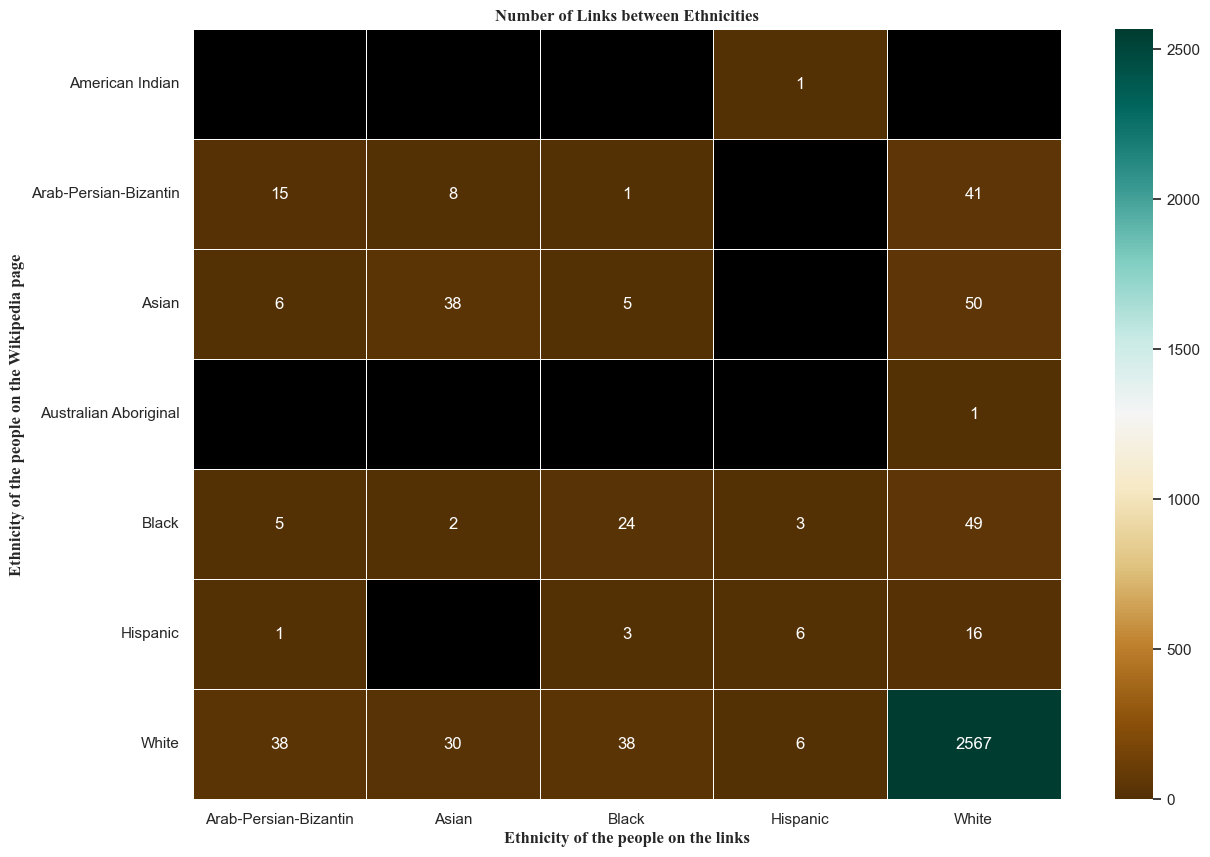

In [25]:
# We want to visualize this data, and a heatmap seems to be the more appropriate method to us: 
heatmap_matrix = ethnic_pair.pivot_table(values='nb_links', index='E_ethnicity', columns='l_ethnicity', fill_value=0)
sns.set(style="whitegrid")

cmap = sns.color_palette("BrBG", as_cmap=True)
cmap.set_bad(color='black')
norm = Normalize(vmin=heatmap_matrix.values.min(), vmax=heatmap_matrix.values.max())

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_matrix, annot=True, cmap=cmap, fmt=".0f", linewidths=.5, mask=(heatmap_matrix == 0),norm=norm)
plt.title('Number of Links between Ethnicities', fontname="Times New Roman", fontweight="bold")
plt.xlabel('Ethnicity of the people on the links',fontname="Times New Roman", fontweight="bold")
plt.ylabel('Ethnicity of the people on the Wikipedia page',fontname="Times New Roman", fontweight="bold")
plt.show()



In [29]:
# To get something less biased, we'll try to find out the proportion of links between each ethnic group. 
# To do this, we divide each pair of links by the total number of links on wikipedia pages belonging to people of a given ethnic group.  
# This gives us:

links_per_ethnicity= ethnic_pair.groupby(['E_ethnicity']).sum().reset_index()
ethnic_pair['nb_links_reajust']= ethnic_pair.nb_links
for i in range (0, len(links_per_ethnicity)):
    for j in range (0, len(ethnic_pair)):
        if ethnic_pair['E_ethnicity'][j]== links_per_ethnicity['E_ethnicity'][i]: 
            ethnic_pair['nb_links_reajust'][j]= ethnic_pair['nb_links'][j]/links_per_ethnicity['nb_links'][i]

ethnic_pair

/var/folders/hg/s7by_zc16hd9fxwtj6cx5wrr0000gn/T/ipykernel_42673/2834029055.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  links_per_ethnicity= ethnic_pair.groupby(['E_ethnicity']).sum().reset_index()
/var/folders/hg/s7by_zc16hd9fxwtj6cx5wrr0000gn/T/ipykernel_42673/2834029055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethnic_pair['nb_links_reajust'][j]= ethnic_pair['nb_links'][j]/links_per_ethnicity['nb_links'][i]


,E_ethnicity,l_ethnicity,nb_links,nb_links_reajust
0,American Indian,Hispanic,1,1.000000
1,Arab-Persian-Bizantin,Arab-Persian-Bizantin,15,0.230769
2,Arab-Persian-Bizantin,Asian,8,0.123077
3,Arab-Persian-Bizantin,Black,1,0.015385
4,Arab-Persian-Bizantin,White,41,0.630769
5,Asian,Arab-Persian-Bizantin,6,0.060606
6,Asian,Asian,38,0.383838
7,Asian,Black,5,0.050505
8,Asian,White,50,0.505051
9,Australian Aboriginal,White,1,1.000000


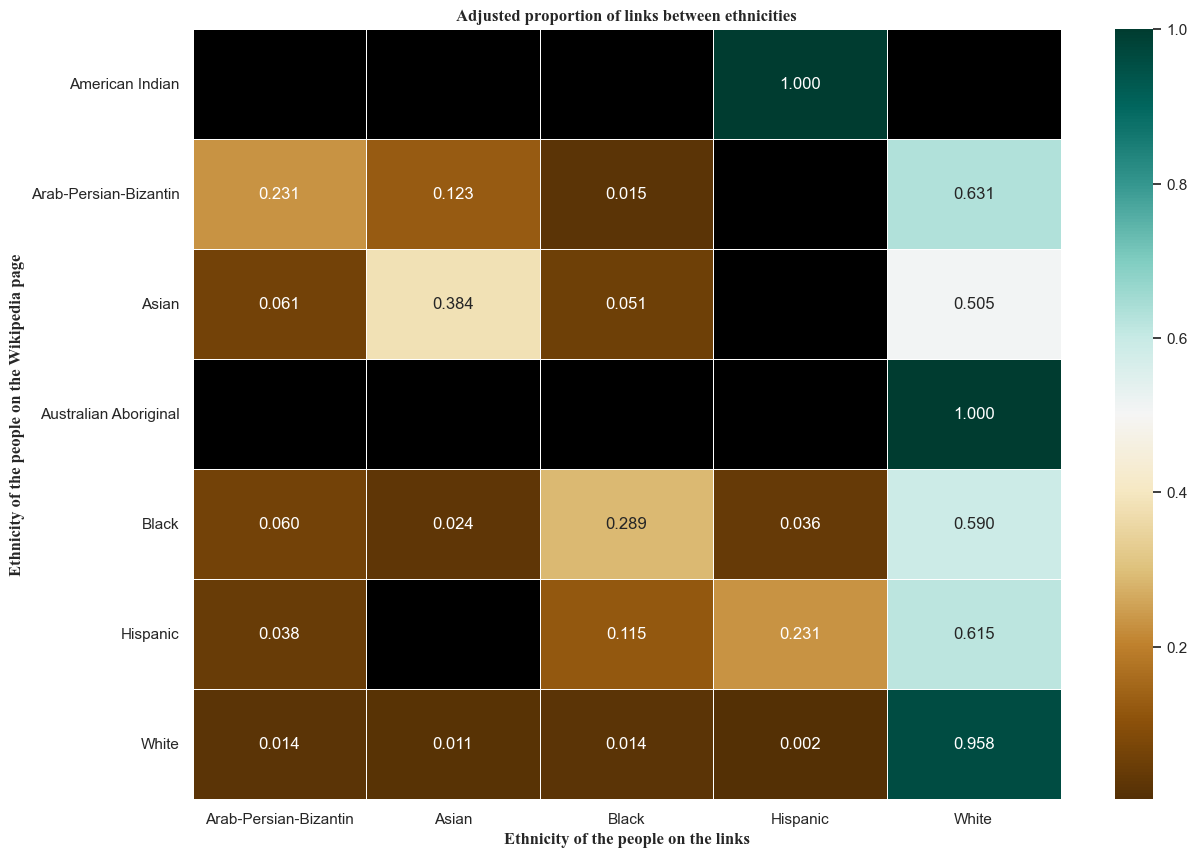

In [20]:
# We want to visualize this data, and again a heatmap seems to be the more appropriate method to us: 
heatmap_matrix = ethnic_pair.pivot_table(values='nb_links_reajust', index='E_color', columns='l_color', fill_value=0)
sns.set(style="whitegrid")

cmap = sns.color_palette("BrBG", as_cmap=True)
cmap.set_bad(color='black')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_matrix, annot=True, cmap=cmap, fmt=".3f", linewidths=.5, mask=(heatmap_matrix == 0))
plt.title('Adjusted proportion of links between ethnicities',fontname="Times New Roman", fontweight="bold")
plt.xlabel('Ethnicity of the people on the links',fontname="Times New Roman", fontweight="bold")
plt.ylabel('Ethnicity of the people on the Wikipedia page',fontname="Times New Roman", fontweight="bold")
plt.show()